In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import datetime
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 20,20

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Lambda, InputLayer, Input, Layer
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.applications import VGG19

import tensorflow as tf

from keras.optimizers import Adam

import skimage

import os

import GPUtil

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Get the first available GPU
# Set CUDA_VISIBLE_DEVICES to mask out all other GPUs than the first available device id
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [3]:
orig_src = rasterio.open('/osn2/home/mlababidi/hdfabio/org_17JUN10112501-P3DS-056944230010_Paris.tif')

orig = orig_src.read(window=((10000,20000),(10000,20000)))

sr_src = rasterio.open('/osn2/home/mlababidi/hdfabio/hd_17JUN10112501-P3DS-056944230010_Paris.tif')

sr = sr_src.read(window=((20000,40000),(20000,40000)))

# orig_train = rolling_window(orig,(5,5)).reshape((-1, 5,5, 1))

# sr_train = rolling_window(sr,(2,2), asteps=(2,2))[0, 2:-2,2:-2].reshape((-1, 2,2, 1))

In [4]:
sz = 128

orig_windows = skimage.util.view_as_windows(orig[0],(sz, sz),sz)
orig_windows = np.reshape(orig_windows, (-1, sz, sz, 1))

sr_windows = skimage.util.view_as_windows(sr[0],(sz*2, sz*2),sz*2)
sr_windows = np.reshape(sr_windows, (-1, sz*2, sz*2, 1))

In [5]:

def SubpixelConv2D(scale=2, name="subpixel"):
    """
    Keras layer to do subpixel convolution.
    NOTE: Tensorflow backend only. Uses tf.depth_to_space
    Ref:
        [1] Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network
            Shi et Al.
            https://arxiv.org/abs/1609.05158
    :param name:
    :param scale: upsampling scale. Default=4
    :return:
    """
    # upsample using depth_to_space
    def subpixel_shape(in_shape):
        if in_shape[1] is None:
            outshape1 = None
        else:
            outshape1 = in_shape[1]*scale
        if in_shape[2] is None:
            outshape2 = None
        else:
            outshape2 = in_shape[2]*scale
        return tuple([in_shape[0], outshape1, outshape2, int(in_shape[3] // (scale*scale))])

    def subpixel(x):
        return tf.depth_to_space(x, scale)

    return Lambda(subpixel, output_shape=subpixel_shape, name=name)


In [23]:
vgg = VGG19(False)
vgg.trainable = False
# outputs = [layer.output for layer in vgg.layers if layer.name.endswith('pool')]
outputs = [layer.output for layer in vgg.layers[1:2]]
vgg_f = Model(vgg.input, outputs)

In [22]:
o = outputs[0]

In [ ]:
o.

In [ ]:
y_vgg = vgg_f.predict(np.repeat(sr_windows, 3, -1))

In [17]:
y_vgg.shape

(16, 256, 256, 64)

In [14]:
outputs

[<tf.Tensor 'block1_conv1_3/Relu:0' shape=(?, ?, ?, 64) dtype=float16>]

In [26]:
vgg_f(repeat)

<tf.Tensor 'model_7/block1_conv1/Relu:0' shape=(?, 256, 256, 64) dtype=float16>

In [10]:
[layer.name for layer in vgg.layers ]

['input_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [28]:
act = "linear"
input_layer = Input((sz, sz, 1))
x = Conv2D(256, kernel_size=(5, 5),
                 activation=act,
                 input_shape=(None, None, 1),
                 name="conv1",
                padding='same'
                )(input_layer)

x = Conv2D(256, kernel_size=(1, 1),
                 activation=act, 
                 name='conv2',
                padding='same')(x)
x = Conv2D(256, kernel_size=(1, 1),
                 activation=act, 
                 name='conv3',
                padding='same')(x)
x = Conv2D(256, kernel_size=(1, 1),
                 activation=act, 
                 name='conv3',
                padding='same')(x)
x = Conv2D(4, kernel_size=(1,1), 
                 activation='relu', 
                 name='hd_pixels',
                padding='same')(x)
x = SubpixelConv2D(scale=2, name='subpixel2')(x)

repeat = Lambda(lambda z: K.repeat_elements(z, 3, -1))(x)

model = Model(input_layer, [x, vgg_f(repeat)])

In [27]:
x

<tf.Tensor 'subpixel2/DepthToSpace:0' shape=(?, 256, 256, 1) dtype=float16>

In [29]:
model.compile(Adam(1e-4), 'mse') # {'out': crossentropy_logits, 'vgg19': 'mse'})

In [31]:
!sudo mkdir /osn/model/quickres

Password:


In [32]:
model.fit(orig_windows, [sr_windows] + y_vgg, batch_size=4, epochs=40)
model.save('/osn/model/quickres/'+'superres_v3_{}.h5'.format(datetime.datetime.now()))

ValueError: operands could not be broadcast together with shapes (1,6084,256,256,1) (16,256,256,64) 

In [108]:
model.save('/osn2/share/HDCNN/'+'superres_v3_{}.h5'.format(datetime.datetime.now()))

In [4]:
model = keras.models.load_model('/osn2/share/HDCNN/superres_v3_2018-01-17 18:48:27.481512.h5')

TypeError: arg 5 (closure) must be None or tuple

In [82]:
dco = rasterio.open('/home/mlababidi/mla/mla/org_15AUG04160516-P3DS-056946717010_WashingtonDC.tif').read(window=((2000,4000),(2000,4000)))
dc = rasterio.open('/home/mlababidi/mla/mla/hd_15AUG04160516-P3DS-056946717010_WashingtonDC.tif').read(window=((4000,8000),(4000,8000)))

In [94]:
profile = src.profile
profile['height'] =3497
profile['width'] *=3497

with rasterio.open('/osn/share/ml_pansh.tif', 'w', **profile) as f:
    f.write(pred[0].transpose([2,0,1]).astype(np.uint16))

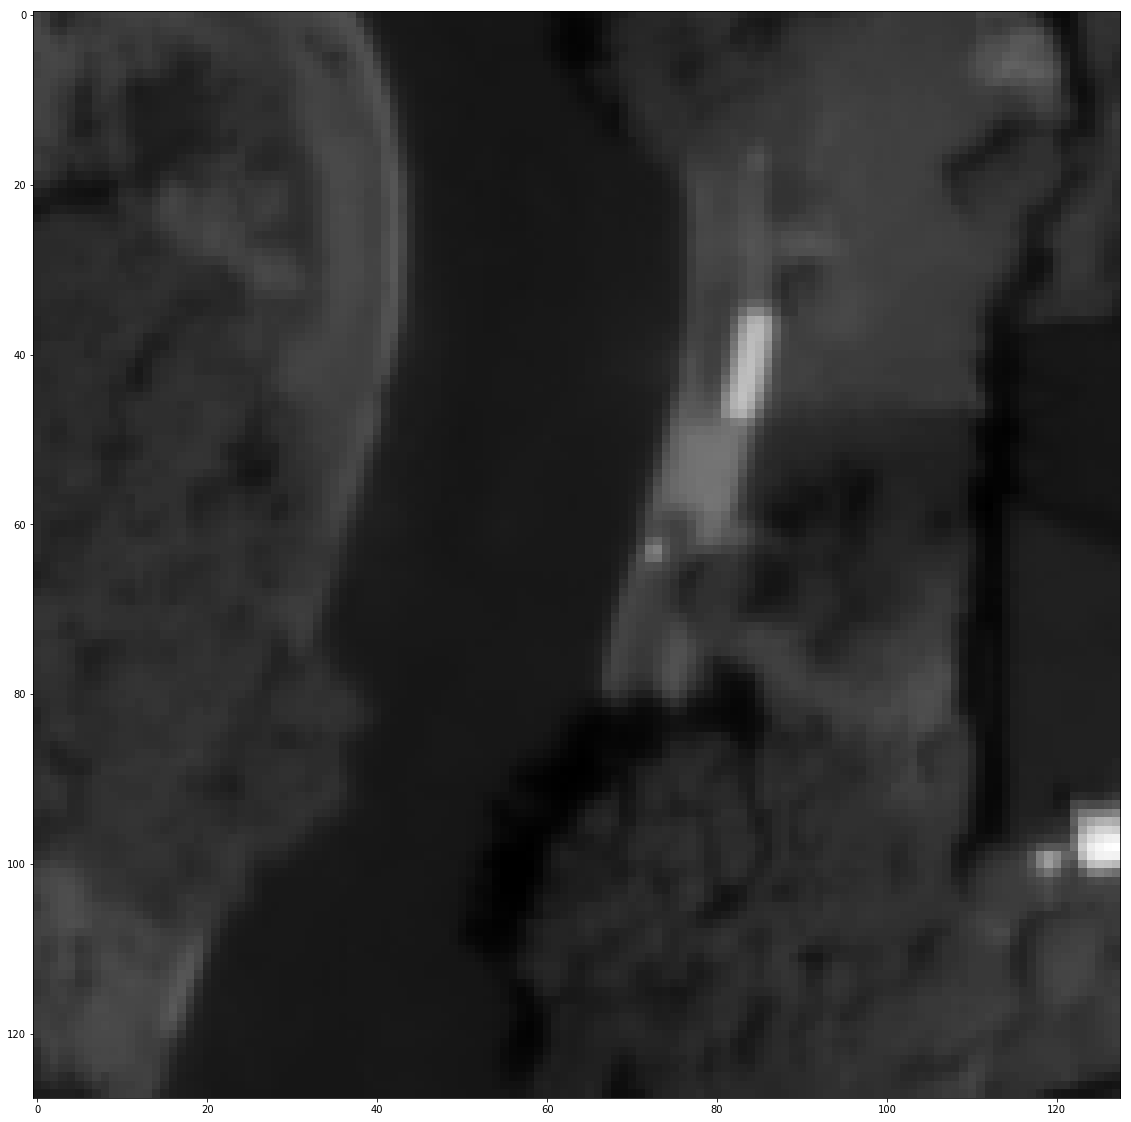

In [99]:
plt.imshow(dco[0, :128, :128], cmap='gray')

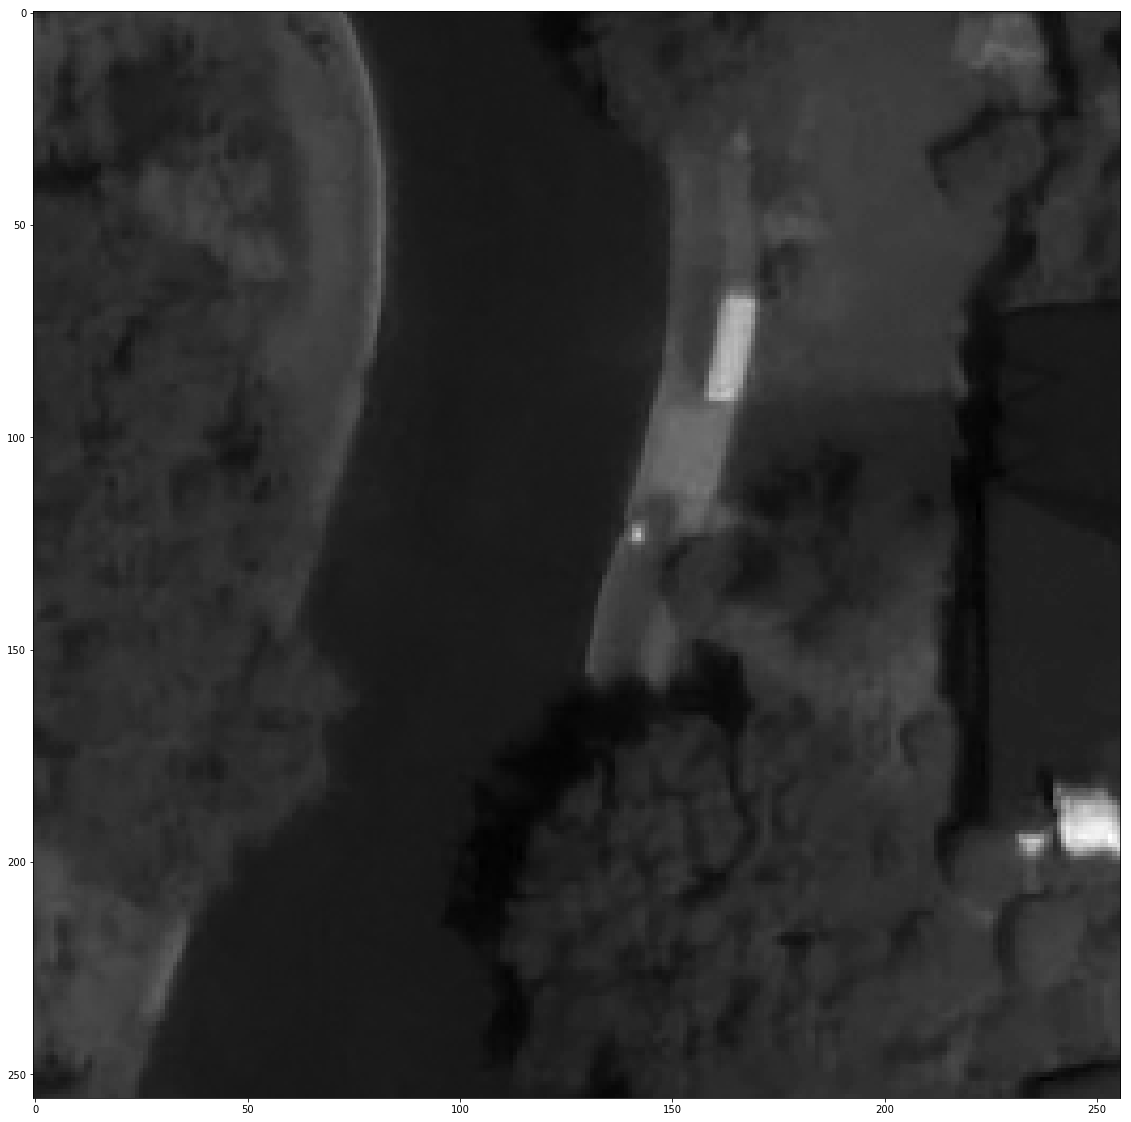

In [100]:
plt.imshow(dc[0, 4:256+4, 4:256+4], cmap='gray')

In [111]:
%%time
pred = model.predict(np.expand_dims(dco[:,0:128, 0:128], -1))
n = pred[0].shape[1]
dc_hd = pred[0][0]

CPU times: user 32 ms, sys: 48 ms, total: 80 ms
Wall time: 46.1 ms


In [96]:
dc_hd.shape

(256, 256, 1)

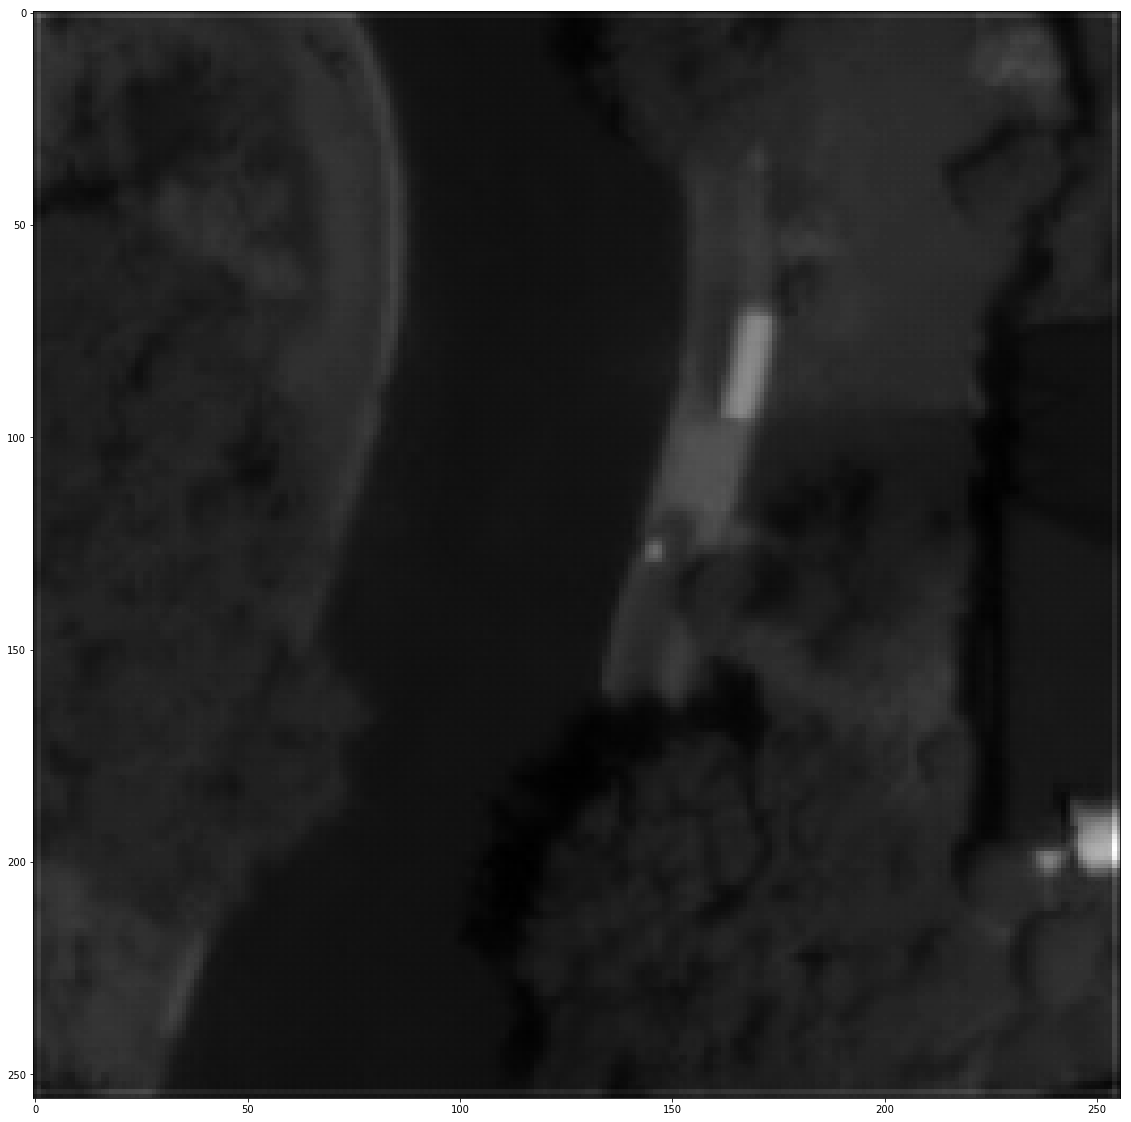

In [112]:
plt.imshow(dc_hd[:,:,0], cmap='gray')

In [ ]:
 _ = plt.hist((dc_hd - dc[0, 4:256+4, 4:256+4]).flatten(), range(-100,100), log=True)

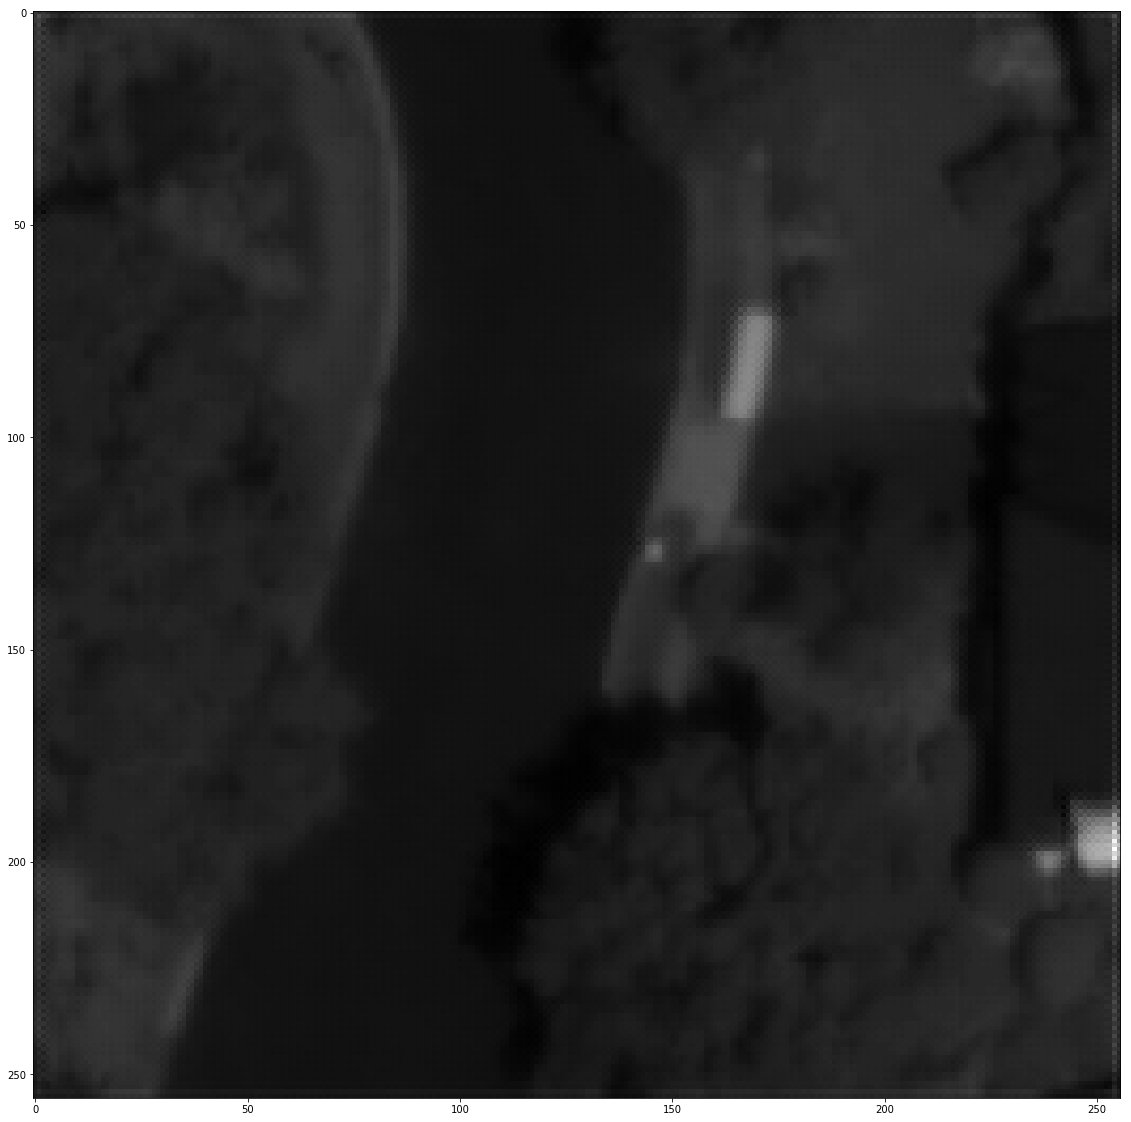

In [97]:
plt.imshow(dc_hd[:,:,0], cmap='gray')

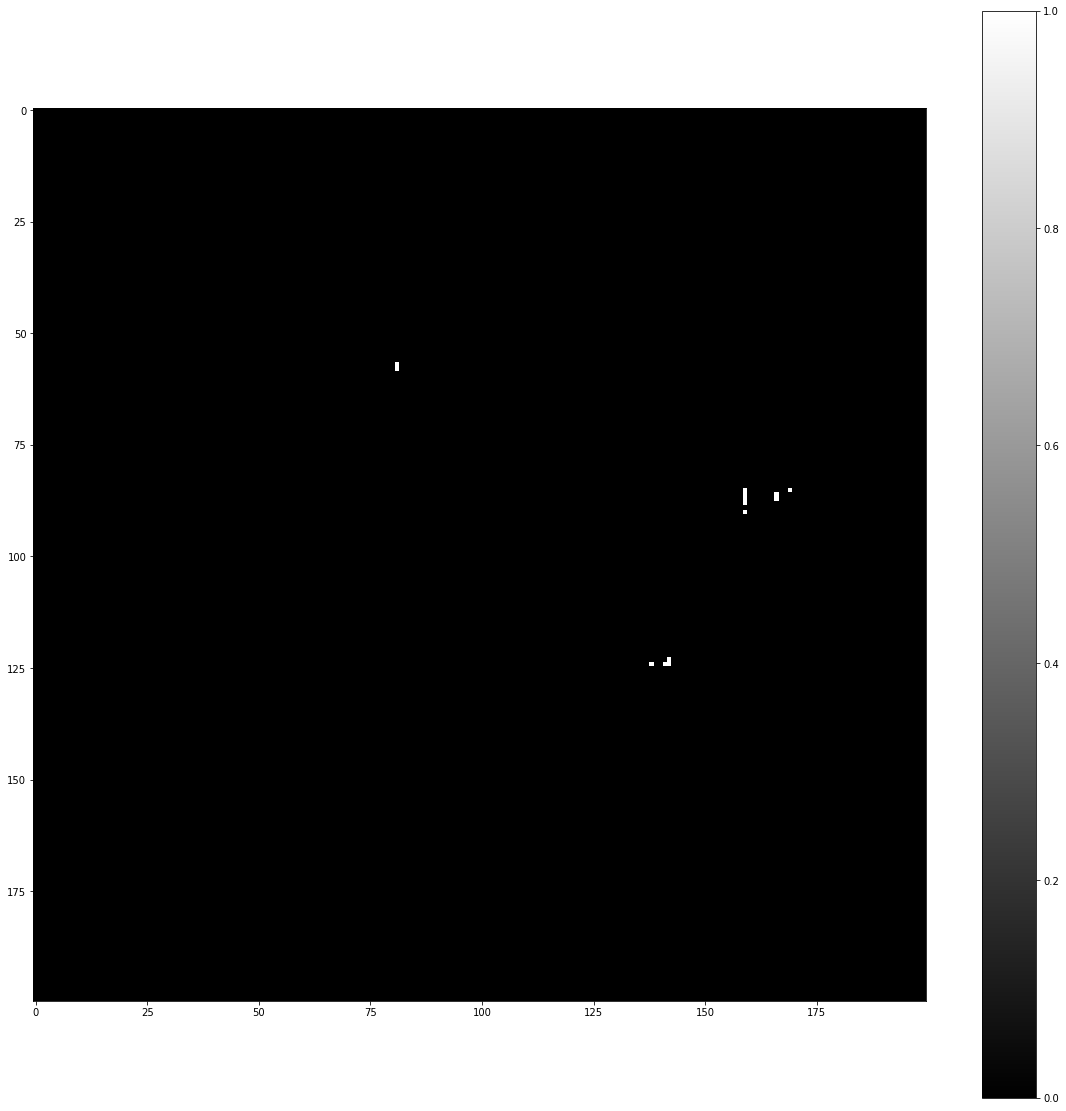

In [60]:
plt.imshow((dc[0, 4:2000-4, 4:2000-4]-dc_hd[:2000, :2000])[:200,:200]>50, cmap='gray')
plt.colorbar()

In [69]:
np.mean(np.square(dc_hd - dc[0, 4:1996, 4:1996]))

NameError: name 'dc_hd' is not defined

In [ ]:
plt.hist((dc[0, 4:1996, 4:1996]).flatten(), range(-100,3000), log=True)

In [ ]:
plt.hist((dc_hd).flatten(), range(-100,3000), log=True)
plt.hist((dc[0, 4:1996, 4:1996]).flatten(), range(-100,3000), log=True)

(array([  1.00000000e+00,   4.00000000e+00,   8.00000000e+00,
          4.00000000e+00,   6.00000000e+00,   7.00000000e+00,
          5.00000000e+00,   6.00000000e+00,   1.00000000e+01,
          5.00000000e+00,   1.00000000e+01,   6.00000000e+00,
          1.00000000e+01,   2.00000000e+00,   8.00000000e+00,
          8.00000000e+00,   6.00000000e+00,   9.00000000e+00,
          1.00000000e+01,   1.20000000e+01,   9.00000000e+00,
          1.70000000e+01,   2.00000000e+01,   1.50000000e+01,
          1.10000000e+01,   1.40000000e+01,   1.50000000e+01,
          1.20000000e+01,   2.00000000e+01,   2.10000000e+01,
          2.10000000e+01,   2.20000000e+01,   2.00000000e+01,
          2.50000000e+01,   2.00000000e+01,   2.40000000e+01,
          2.30000000e+01,   2.50000000e+01,   2.00000000e+01,
          2.40000000e+01,   3.50000000e+01,   2.10000000e+01,
          3.20000000e+01,   4.30000000e+01,   4.40000000e+01,
          3.60000000e+01,   5.50000000e+01,   4.60000000e+01,
        

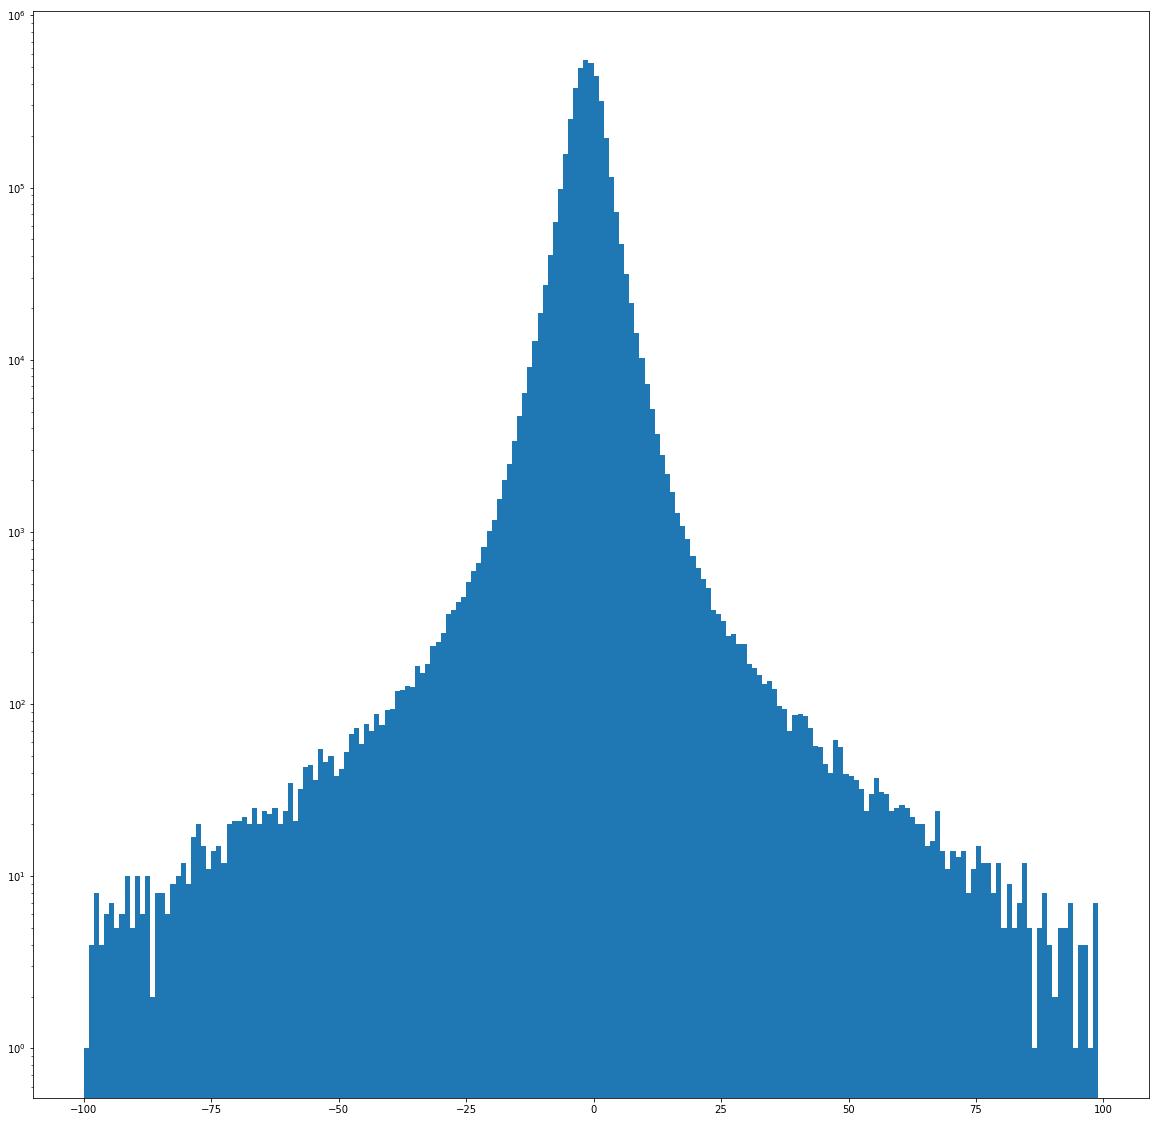

In [76]:
plt.hist((dc_hd - dc[0, 4:1996, 4:1996]).flatten(), range(-100,100), log=True)

In [4]:
dco = rasterio.open('/home/mlababidi/b/mla/mla/org_15AUG04160516-P3DS-056946717010_WashingtonDC.tif')

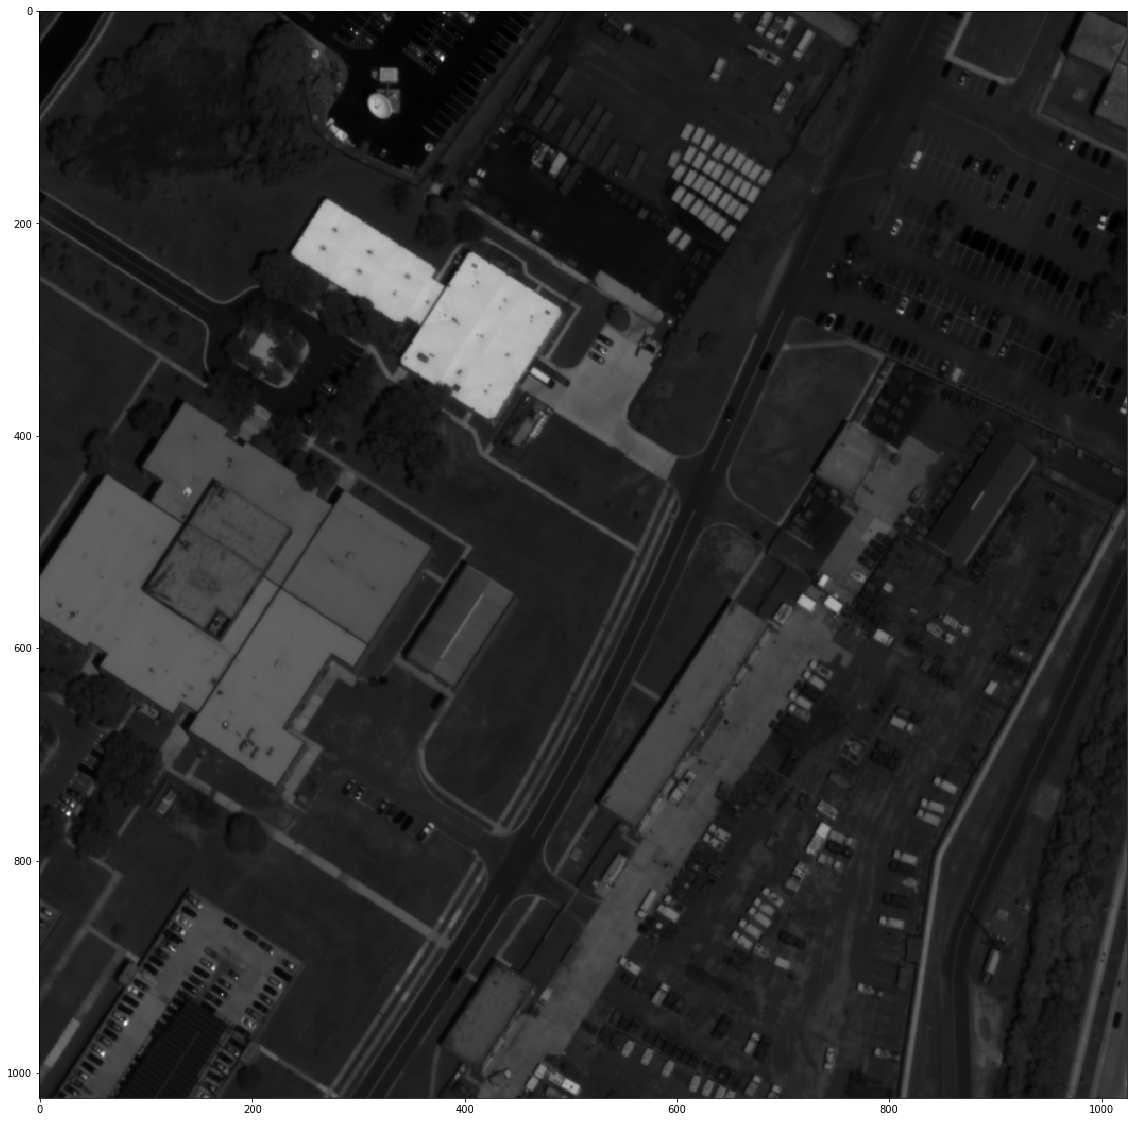

In [46]:
l = 23
m = 35
orig = dco.read(window=((int((l-1)*1024),int(l*1024)),((m-1)*1024,m*1024)))

plt.imshow(orig[0], cmap='gray')

In [47]:
orig.shape

(1, 1024, 1024)

In [51]:
((int((l-1)*1024),int(l*1024)),((m-1)*1024,m*1024))

((22528, 23552), (34816, 35840))

In [14]:
((int((l-1)*1024),int(l*1024)),((m-1)*1024,m*1024))

((10752, 11776), (26624, 27648))

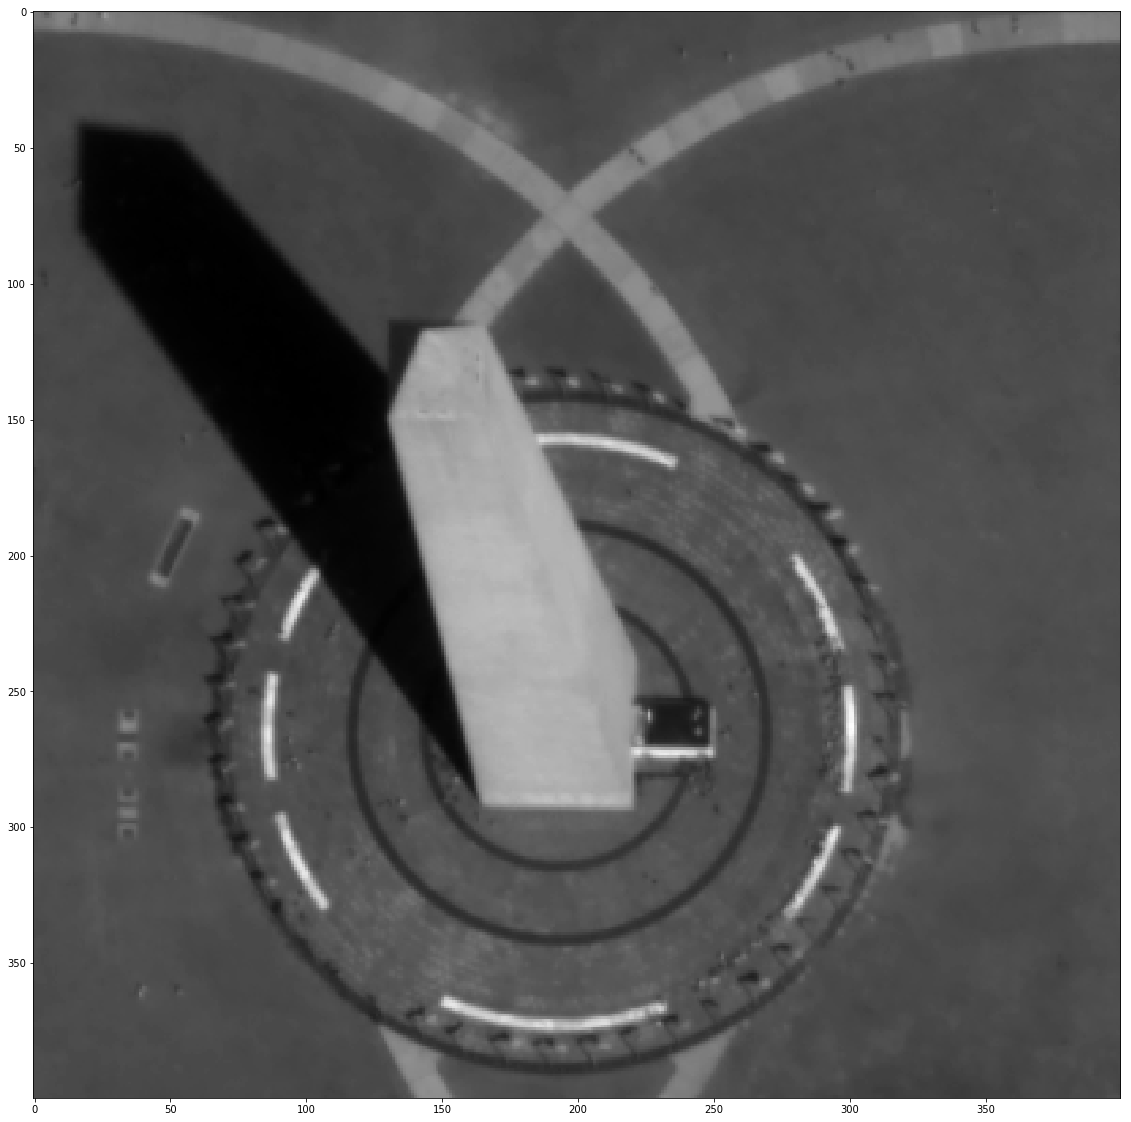

In [24]:
orig = dco.read(window=((10752+300, 11776-300-24), (26624+580, 27648-50+6)))

plt.imshow(orig[0], cmap='gray')

In [23]:
orig.shape

(1, 424, 400)

In [25]:
pred = model.predict(np.expand_dims(orig, -1))
n = pred.shape[1]
mon = pred.reshape(n,n,2,2).transpose([0,2,1,3]).reshape(2*n,2*n)

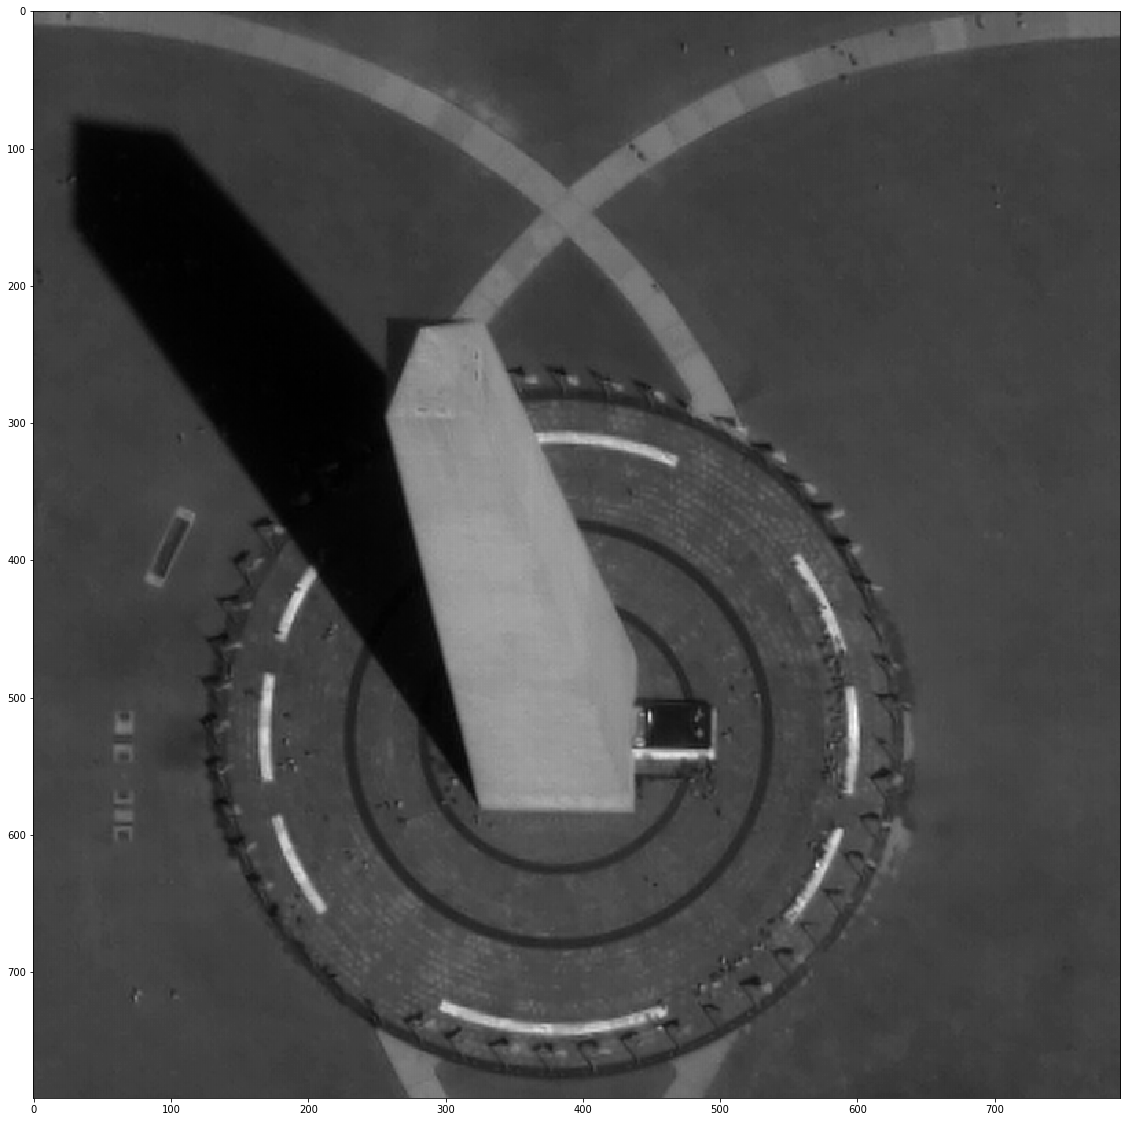

In [26]:
plt.imshow(mon, cmap='gray')

In [55]:
orig = dco.read(window=((22528+512, 23552), (34816+512, 35840)))



In [56]:
pred = model.predict(np.expand_dims(orig, -1))
n = pred.shape[1]
trucks = pred.reshape(n,n,2,2).transpose([0,2,1,3]).reshape(2*n,2*n)

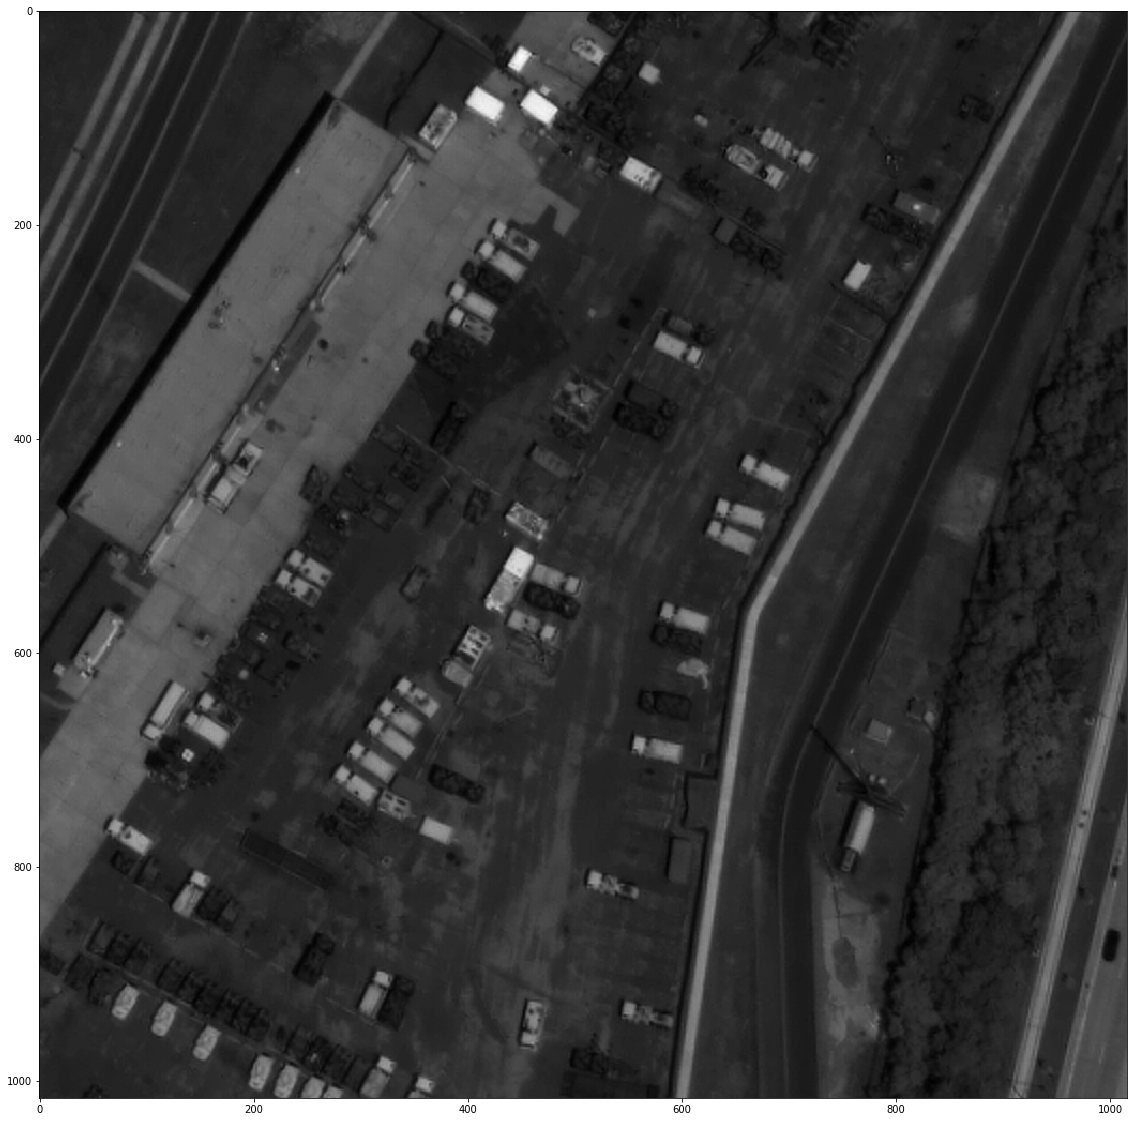

In [57]:
plt.imshow(trucks, cmap='gray')

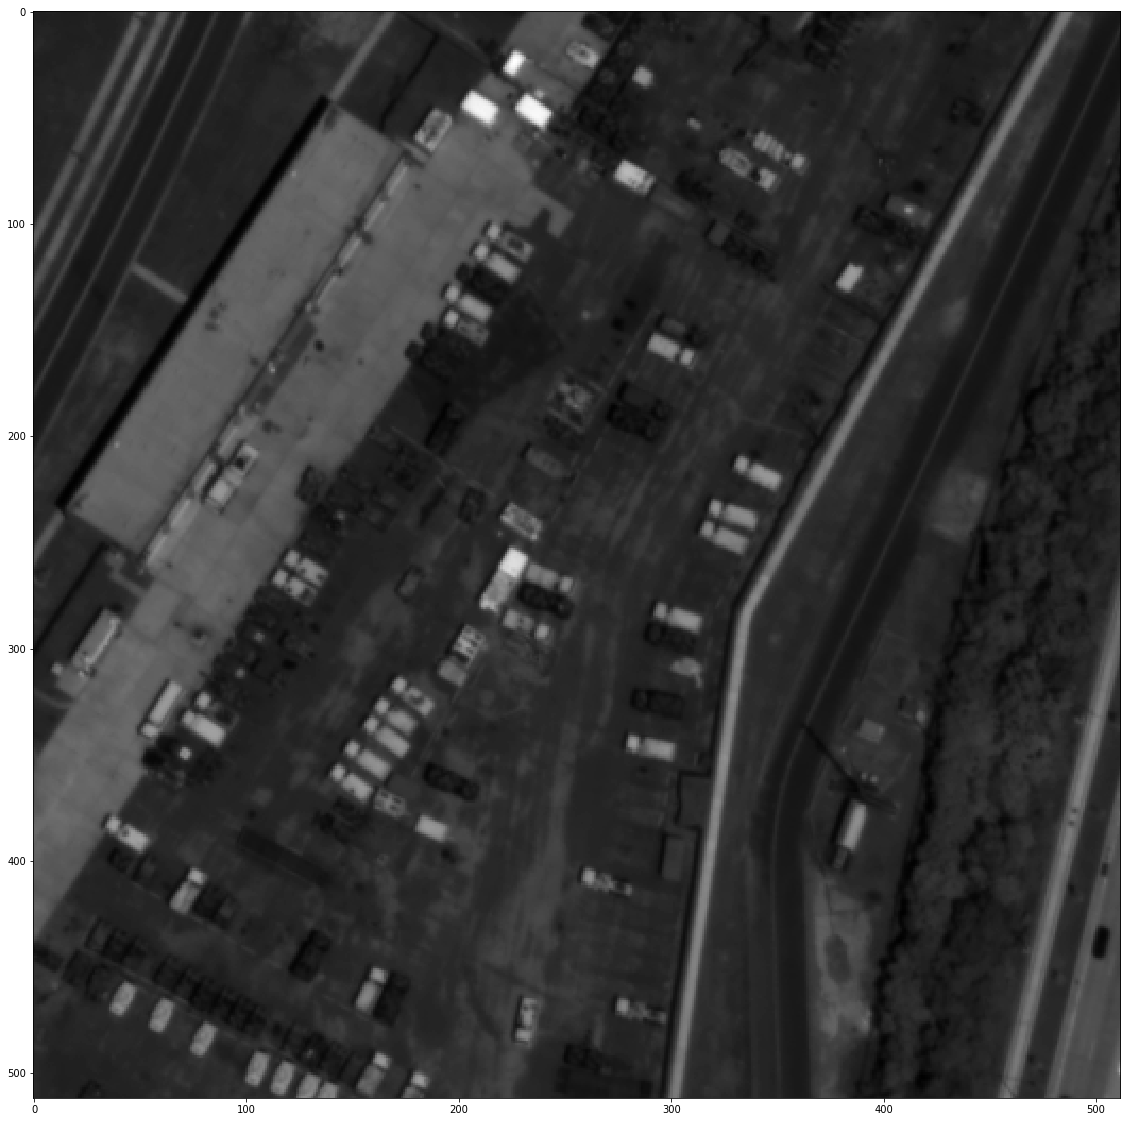

In [59]:
plt.imshow(orig[0],cmap='gray')